In [2]:
#From:http://software.rc.fas.harvard.edu/ngsdata/workshops/2015_March/DESeq2_fruitfly.html
library('ggplot2')
library('DESeq2')
library('RColorBrewer')

Warning message:
: package ‘ggplot2’ was built under R version 3.2.3Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loadin

Here we grab all files from new Kallisto run.

To obtain these Kallisto files: 
- We removed all mitochondrial genes, because they showed a very high amount of variation which we believed might cloud our results.
- We also used mean length of transcript from Lene file as input.


In [3]:
base_dir <- "~/Desktop/KallistoFiles/results2"
sample_names1<-list.files(base_dir)
sample_names1<-sample_names1[sample_names1!="Zi238_C4_AGTTCC"]
sample_names<-gsub('.{7}$', '', sample_names1)
sample_names
kal_dirs <- sapply(sample_names1, function(id) file.path(base_dir, id))

[1] "Fr188_C1" "Fr188_C2" "Fr188_C3" "Fr188_T3" "Fr188_T5" "Fr188_T6"
 [7] "Fr89_C1"  "Fr89_C2"  "Fr89_C4"  "Fr89_T3"  "Fr89_T4"  "Fr89_T5" 
[13] "Zi238_C1" "Zi238_C2" "Zi238_C3" "Zi238_T2" "Zi238_T3" "Zi238_T4"
[19] "Zi257_C1" "Zi257_C2" "Zi257_C3" "Zi257_T1" "Zi257_T2" "Zi257_T3"
[25] "Zi257_T4"

We create a count data dataframe to store the tpms from these files.  We convert these to integers.  We store these in a matrix called "countData".  

In [4]:
#variable countData: all of the tpm info for all of the Kallisto files, rounded to integers.

countData <- as.character(read.table(file.path(kal_dirs[1], "abundance.tsv"), header = TRUE)$target_id)
for (dir in kal_dirs){
  z<-read.table(file.path(dir, "abundance.tsv"), header=TRUE)
  countData<-data.frame(countData, as.integer(z$est_counts))  #converting to integers
}

#Setting row and column names for countData
colnames(countData)=c("target_id", sample_names1)
countData$target_id=read.table(file.path(kal_dirs[1], "abundance.tsv"), header = TRUE)$target_id
rownames(countData)=countData$target_id
countData$target_id=NULL

We now load conditions file, and display it below.

In [5]:
#variable colData: All of the conditions information for the differnt samples

#The conditions dataset is hiseq_infoAll
colData<-read.table("~/Desktop/KallistoFiles/hiseq_infoAll.txt", header=T, stringsAsFactors=FALSE, sep="\t")
colData<-colData[match(colnames(countData), colData$sample),]
colData
rownames(colData)=colData$sample
colData$sample = NULL
colData$lane = factor(colData$lane)
colData$lines = factor(colData$lines)

sample country lines tissue lane
1  Fr188_C1_TTAGGC      Fr   188      C    1
6  Fr188_C2_GATCAG      Fr   188      C    2
11 Fr188_C3_GGCTAC      Fr   188      C    1
16 Fr188_T3_GTCCGC      Fr   188      T    1
21 Fr188_T5_ATGTCA      Fr   188      T    2
2  Fr188_T6_CCGTCC      Fr   188      T    2
7   Fr89_C1_CGATGT      Fr    89      C    2
12  Fr89_C2_AGTCAA      Fr    89      C    2
17  Fr89_C4_CAGATC      Fr    89      C    1
22  Fr89_T3_ACTGAT      Fr    89      T    1
3   Fr89_T4_ATTCCT      Fr    89      T    1
8   Fr89_T5_GAGTGG      Fr    89      T    2
13 Zi238_C1_CAGATC      Zi   238      C    2
18 Zi238_C2_CTTGTA      Zi   238      C    2
23 Zi238_C3_ATCACG      Zi   238      C    2
9  Zi238_T2_TGACCA      Zi   238      T    1
14 Zi238_T3_ACAGTG      Zi   238      T    2
19 Zi238_T4_GCCAAT      Zi   238      T    1
24 Zi257_C1_TAGCTT      Zi   257      C    1
4  Zi257_C2_GTTTCG      Zi   257      C    2
10 Zi257_C3_GTGGCC      Zi   257      C    1
15 Zi257_T1_ATCACG      Zi   257      T    1
20 Zi257_T2_CGTACG      Zi   257      T    2
25 Zi257_T3_CGATGT      Zi   257      T    1
5  Zi257_T4_GTGAAA      Zi   257      T    2

In [6]:
#You can disregard this.
datasetInteract <- DESeqDataSetFromMatrix(countData = countData,
                                  colData = colData,
                                  design = ~lines + tissue+ lines:tissue+ lane)

dataset <- DESeqDataSetFromMatrix(countData = countData,
                                          colData = colData,
                                          design = ~lines + tissue+lane)

datasetNoLane <- DESeqDataSetFromMatrix(countData = countData,
                                            colData = colData,
                                            design = ~lines + tissue)

datasetNoLaneInteract <- DESeqDataSetFromMatrix(countData = countData,
                                        colData = colData,
                                        design = ~lines + tissue + lines:tissue)


Warning message:
In DESeqDataSet(se, design = design, ignoreRank): some variables in design formula are characters, converting to factorsWarning message:
In DESeqDataSet(se, design = design, ignoreRank): some variables in design formula are characters, converting to factorsWarning message:
In DESeqDataSet(se, design = design, ignoreRank): some variables in design formula are characters, converting to factorsWarning message:
In DESeqDataSet(se, design = design, ignoreRank): some variables in design formula are characters, converting to factors

The biggest differences in gene expression are between carcass and testes.  We are most interested in the effect of line, and so we divide our dataset into carcass data and testes data.

We also create, for each tissue, DESeq datasets, conditioning on lines and lane.  lane is a control - we expect it to have no effect.

In [7]:
##dataset C -- just carcass data
colDataC<-colData[colData$tissue=='C',]
countDataC<-countData[,colnames(countData) %in% rownames(colDataC)]
datasetC <- DESeqDataSetFromMatrix(countData = countDataC,
                                   colData = colDataC,
                                   design = ~lines + lane)

##dataset T -- just testes data
colDataT<-colData[colData$tissue=='T',]
countDataT<-countData[,colnames(countData) %in% rownames(colDataT)]
datasetT <- DESeqDataSetFromMatrix(countData = countDataT,
                                   colData = colDataT,
                                   design = ~lines + lane)

Here we create DESeq object files from our DESeq datasets.

In [8]:
ddsC<-DESeq(datasetC)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [9]:
ddsT<-DESeq(datasetT)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing


We constrast different lines with the carcass data.  The biggest difference is between 257 and 238.

In [10]:
print("lane 1 vs 2 (control)")
summary(results(ddsC, contrast=c('lane','1','2')), alpha=0.05)

print("lines 188 vs 238")
summary(results(ddsC, contrast=c('lines','188','238')), alpha=0.05) #nothing
print("lines 188 vs 89")
summary(results(ddsC, contrast=c('lines','188','89')), alpha=0.05) #nothing
print("lines 188 vs 257")
summary(results(ddsC, contrast=c('lines','188','257')), alpha=0.05) #something
print("lines 257 vs 238")
summary(results(ddsC, contrast=c('lines','257','238')), alpha=0.05) #something bigger
print("lines 257 vs 89")
summary(results(ddsC, contrast=c('lines','257','89')), alpha=0.05) #something 
print("lines 89 vs 238")
summary(results(ddsC, contrast=c('lines','89', '238')), alpha=0.05) #something

[1] "lane 1 vs 2 (control)"

out of 28822 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 13, 0.045% 
LFC < 0 (down)   : 11, 0.038% 
outliers [1]     : 634, 2.2% 
low counts [2]   : 3225, 11% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 238"

out of 28822 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 20, 0.069% 
LFC < 0 (down)   : 11, 0.038% 
outliers [1]     : 634, 2.2% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 89"

out of 28822 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 6, 0.021% 
LFC < 0 (down)   : 11, 0.038% 
outliers [1]     : 634, 2.2% 
low counts [2]   : 2707, 9.4% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 257"

We contrast different lines with the testes data -- all the effects are smaller, and the biggest effect is again 257 vs 238

In [11]:
print("lane 1 vs 2 (control)")
summary(results(ddsT, contrast=c('lane','1','2')), alpha=0.05)

print("lines 188 vs 238")
summary(results(ddsT, contrast=c('lines','188','238')), alpha=0.05) 
print("lines 188 vs 89")
summary(results(ddsT, contrast=c('lines','188','89')), alpha=0.05) 
print("lines 188 vs 257")
summary(results(ddsT, contrast=c('lines','188','257')), alpha=0.05) 
print("lines 257 vs 238")
summary(results(ddsT, contrast=c('lines','257','238')), alpha=0.05) #biggest effect (still not very big)
print("lines 257 vs 89")
summary(results(ddsT, contrast=c('lines','257','89')), alpha=0.05)  
print("lines 89 vs 238")
summary(results(ddsT, contrast=c('lines','89', '238')), alpha=0.05) 

[1] "lane 1 vs 2 (control)"

out of 28486 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 23, 0.081% 
LFC < 0 (down)   : 30, 0.11% 
outliers [1]     : 0, 0% 
low counts [2]   : 18160, 64% 
(mean count < 76)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 238"

out of 28486 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 14, 0.049% 
LFC < 0 (down)   : 19, 0.067% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 89"

out of 28486 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 12, 0.042% 
LFC < 0 (down)   : 21, 0.074% 
outliers [1]     : 0, 0% 
low counts [2]   : 546, 1.9% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 257"

out of 28

From above (well, two cells up), we see that mostly there is a difference per line in the carcass data.  We do a LRT to see if line is significant, compared to the reduced model.

In [12]:
#variable rownames(results.line.ordered.C): the top genes (by adjusted pval) that show a difference by line in the carcass data

#line test for carcass
ddsC.line<-nbinomLRT(ddsC, reduced=~lane)
results.line.C<-results(ddsC.line)
results.line.ordered.C<-results.line.C[order(results.line.C$padj),]
summary(results.line.C)
results.line.C

found results columns, replacing these



out of 28822 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 266, 0.92% 
LFC < 0 (down)   : 593, 2.1% 
outliers [1]     : 251, 0.87% 
low counts [2]   : 3343, 12% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): lane 2 vs 1 
LRT p-value: '~ lines + lane' vs '~ lane' 
DataFrame with 30433 rows and 6 columns
              baseMean log2FoldChange      lfcSE       stat      pvalue
             <numeric>      <numeric>  <numeric>  <numeric>   <numeric>
FBtr0071764  15.313548      1.3235877  0.5726591   5.855813   0.1188399
FBtr0100521 138.134037      1.1131767  0.5843498   4.119913   0.2488034
FBtr0071763  65.232033     -1.8926582  1.3211874   1.731859   0.6298741
FBtr0342981   6.738338     -0.5496449  2.9557711   3.579142   0.3106418
FBtr0083388  43.318354     -0.2975736  0.4755669   4.709848   0.1943188
...                ...            ...        ...        ...         ...
FBtr0079286   21.58718   -1.323485959 1.10303953 14.7714020 0.002022798
FBtr0079333   10.07271    0.655915068 0.51251905  0.1061748 0.991086261
FBtr0079288  203.23186   -0.298199571 0.26493083  1.3749830 0.711409185
FBtr0343157 2532.97925   -0.006314007 0.09595999  5.7657193 0.123581786
FBtr0079289   22

In [13]:
#line test for testes
ddsT.line<-nbinomLRT(ddsT, reduced=~lane)
results.line.T<-results(ddsT.line)
results.line.ordered.T<-results.line.T[order(results.line.T$padj),]
summary(results.line.T)

found results columns, replacing these



out of 28486 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 152, 0.53% 
LFC < 0 (down)   : 150, 0.53% 
outliers [1]     : 0, 0% 
low counts [2]   : 2202, 7.7% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



From the above, we see that line is only all that significant in the carcass data.  It seems to have a much smaller effect in the testes data.

Now we do a heatmap on the 500 most differentially expressed genes by lines in the carcass data, and it looks like things cluster by line and kind of by county too (ish).  We notice that Fr89_C4, and to some extent Zi238_C2 have a whole bunch of underexpressed genes. These are not strains that were flagged by our preliminary analysis in python as having too many zeros (see 20151027_EDA.ipynb).  [The other strain pointed out by the our preliminary analysis in python as having maybe too many zeros was Fr188_T3].  

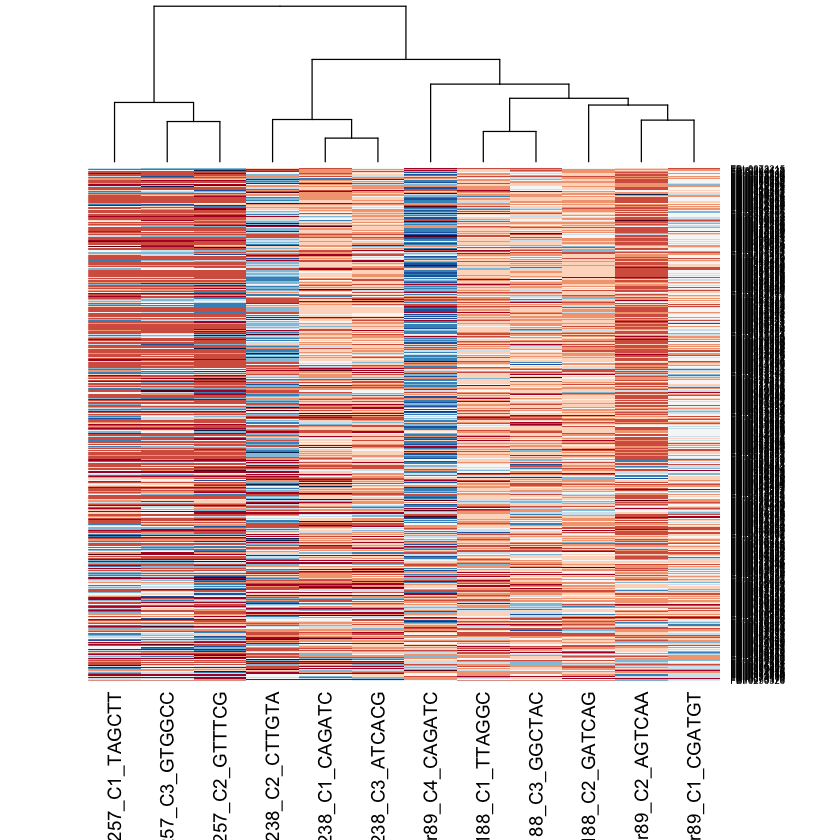

In [14]:
hmcol <- brewer.pal(11,'RdBu')
nCountsC <- counts(ddsC, normalized=TRUE)
heatmap(as.matrix(nCountsC[rownames(results.line.ordered.C)[1:500], ]), Rowv = NA, col = hmcol, mar = c(8,2))

We do the same for the testes data, and don't see any clustering by line

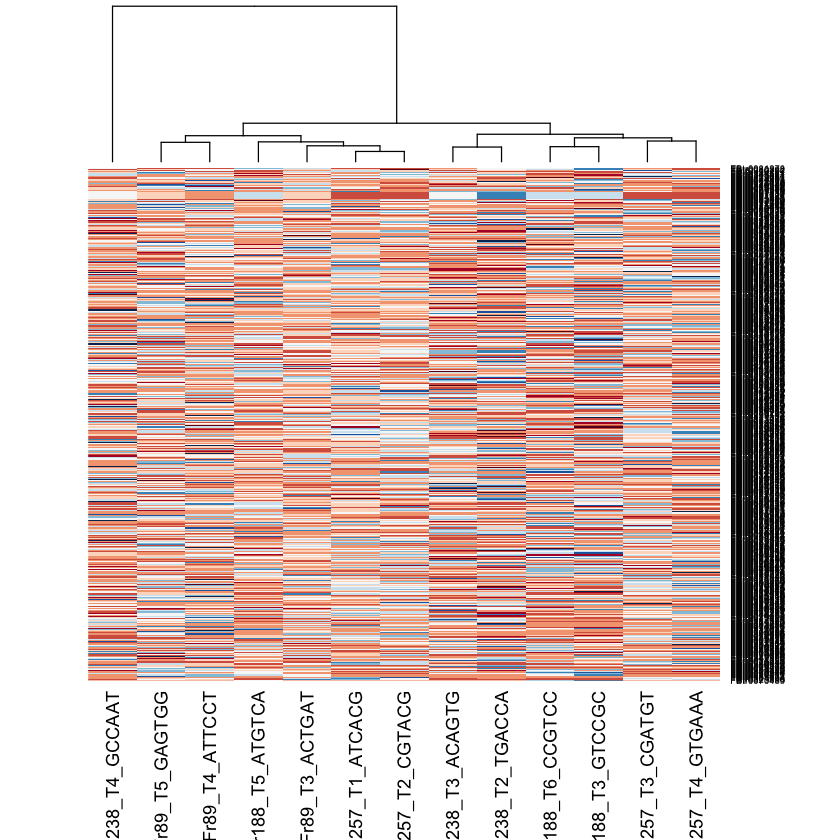

In [15]:
hmcol <- brewer.pal(11,'RdBu')
nCountsT <- counts(ddsT, normalized=TRUE)
heatmap(as.matrix(nCountsT[rownames(results.line.ordered.T)[1:500], ]), Rowv = NA, col = hmcol, mar = c(8,2))

We talked about being more stringent in removing outliers (the other strain that potentially looked like an outlier in the python EDA was Fr188_T3), but it seems like we can ignore testes data for the time being because the differential expression signal is super low.

Now we plot a PCA using the 500 most differentially expressed genes by line.  Looks like PCA2 maybe shows a country effect, but I'm not all that convinced.

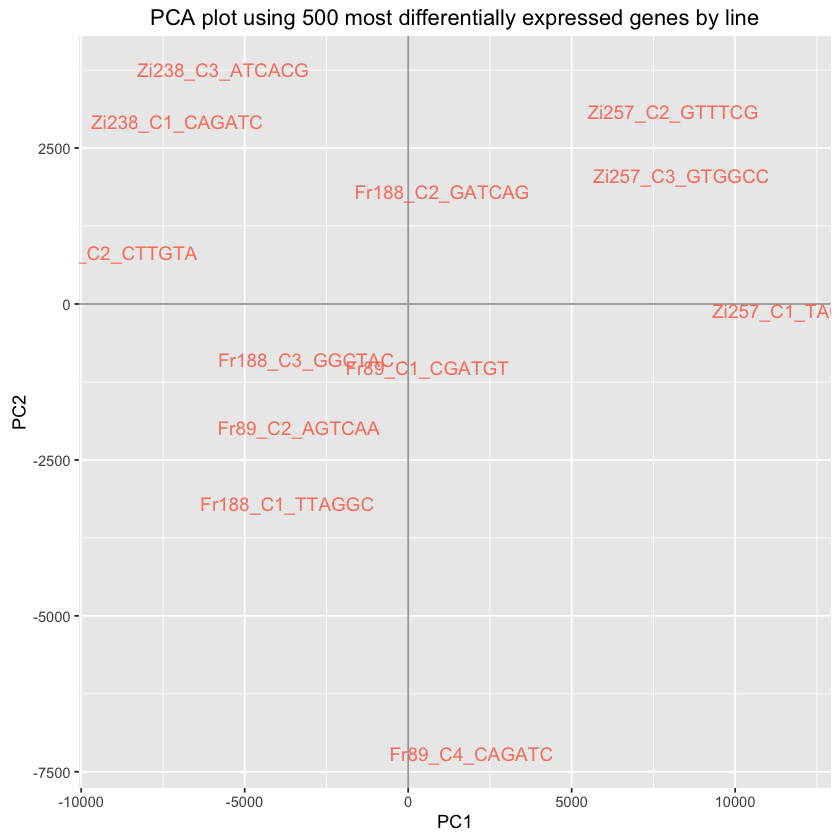

In [16]:
#get normalized counts
pca1<-prcomp(t(as.matrix(nCountsC[rownames(results.line.ordered.C)[1:500], ])))
scores = as.data.frame(pca1$x)

# plot of observations
ggplot(data = scores, aes(x = PC1, y = PC2, label = rownames(scores))) +
  geom_hline(yintercept = 0, colour = "gray65") +
  geom_vline(xintercept = 0, colour = "gray65") +
  geom_text(colour = "tomato", alpha = 0.8, size = 4) +
  ggtitle("PCA plot using 500 most differentially expressed genes by line")

# Next step: compare found genes to Sackton GBE paper found genes

The supplementary material of the Sackton GBE meta-analysis is linked here: "http://gbe.oxfordjournals.org/content/suppl/2013/01/12/evt005.DC1/sup_file_1.tsv".  We load it as a table of `Sacktongenes`

In [17]:
Sacktongenes <- read.table(
  "http://gbe.oxfordjournals.org/content/suppl/2013/01/12/evt005.DC1/sup_file_1.tsv",
  sep="\t", header=TRUE)


In [18]:
head(Sacktongenes)
length(Sacktongenes[,1])
#There are 4271 genes

fbgn chr sigclass all.sig  dmel.avg         cv  cellular_loc dmsp
1 FBgn0000008  2R specific       1 0.4699436 0.46904991      membrane   no
2 FBgn0000014  3R     none       0 0.4496924 0.14027248       nucleus   no
3 FBgn0000036  3R     none       0 0.3308644 0.11442119      membrane   no
4 FBgn0000038  3L     none       0 0.4913641 0.09915834      membrane   no
5 FBgn0000042   X specific       1 0.7656141 0.28474085       nucleus   no
6 FBgn0000043  2R     none       0 0.5226461 0.05774715 intracellular   no
   FbtrLen NumInt FirstIntLen AveIntLen color     m0W  RecomRP intergenic.dist
1 4.554513      9    2.898725  3.537525 BLACK      NA       NA        0.000000
2 4.344923      5    3.010300  3.545851  BLUE 0.03038 2.512977        4.261525
3 4.745894      9    3.580012  3.763794 BLACK 0.00465 3.205108        0.000000
4 3.822560      6    1.806180  2.844166 BLACK 0.01793 3.278810        3.538448
5 3.594282      1    3.224533  3.224533   RED      NA       NA        4.254741
6 3.249687      1    2.190332  2.190332   RED      NA       NA        0.000000
       gpmb window11.length transcript.num    tau.avg     mf.pc1    exp.pc1
1 -3.752847        4.795414              3 0.35434291 -0.9493064 -0.6130555
2 -3.899215        5.167704              4 0.63830078 -0.3405483 -0.6803284
3 -3.724689        5.151214              2 0.90016456  0.1946668 -0.4574673
4 -3.823899        4.886101              4 0.87540349  0.4023412 -0.3782089
5 -3.881319        4.878114              4 0.07764047 -0.9959554  6.0292924
6 -4.097681        4.895671              1 0.17932247 -0.6554756  1.4131835
  postmei.ratio    h2m     Embryo      Larvae      pupae expdivtot.m het
1   -0.21237714     NA   2.185172   0.8446358   2.661192          NA rep
2    0.18745863     NA  11.936504   5.9847983   7.531940     1.58108 rep
3   -0.06374388     NA   2.522274   2.0797408   2.186969     1.39626 rep
4    0.04022984 0.3430  13.921220   7.0573650  18.517542     0.91937 rep
5    0.04507071 0.2260  64.832992 111.3475167 181.535500          NA act
6   -0.03750336 0.0683 408.235667 261.4169333 485.385000          NA act
  Ycongo.Ymass Ycongo.Ycs Ycongo.Yz53 Ycongo.Y4361  Ymass.Ycs Ymass.Yz53
1  -0.26684367  0.2458371  -0.1283616   0.22513673  0.4947913  0.1404150
2  -0.19038851  0.4116478   0.5458252   0.88353507  0.5807296  0.7122474
3   0.01894574 -0.1830603   0.3326228  -0.03683723 -0.1852797  0.2854456
4  -0.48513005  0.4441997   0.1915662   0.66581431  0.8969052  0.6633139
5   0.03105632  1.6522717   0.5284585   0.66863585  1.5625156  0.4767579
6   0.57013936  0.8584109   0.8178305   0.18875263  0.2764599  0.2219468
  Ymass.Y4361    Ycs.Yz53   Ycs.Y4361 Yz53.Y4361  bl08.avg  bl08.max      H7.H5
1  0.46526995 -0.36644085 -0.02857002  0.3456872 0.2707353 0.4947913 0.12149559
2  0.99979853  0.11867475  0.42217409  0.3209955 0.5186016 0.9997985 0.67926844
3 -0.04776916  0.48576516  0.14030554 -0.3463818 0.2062413 0.4857652 0.06543646
4  1.08284424 -0.25447730  0.18871302  0.4587337 0.5331698 1.0828442 0.49366036
5  0.58775852 -1.12377646 -0.97561634  0.1290610 0.7735908 1.6522717 0.39432065
6 -0.37533797 -0.06090888 -0.65405074 -0.6233351 0.4647173 0.8584109 0.25963247
       H15.H5    H23.H5     H15.H7      H23.H7     H23.H15     h.avg     h.max
1 -0.07642945 0.1565460 -0.1655711  0.07306886  0.30287465 0.1493309 0.3028747
2  0.57386253 0.1892679  0.1577600 -0.27016920 -0.54828578 0.4031023 0.6792684
3  0.19256019 0.2378249  0.1618607  0.18493349  0.03378408 0.1460667 0.2378249
4  0.21187144 0.3096416 -0.1017699 -0.04243476  0.07781128 0.2061982 0.4936604
5  0.85336592 0.5858677  0.6542870  0.30943171 -0.42387119 0.5368574 0.8533659
6  0.63810079 0.4259920  0.5168607  0.24381656 -0.33910791 0.4039184 0.6381008
  XXYcongo.XXYohio XXYcongo.XXYindia XXYcongo.XXYzimb XXYindia.XXYohio
1       -2.8200671        -1.5560442       -1.2414400      -0.31372777
2       -1.4758109        -0.1619016        0.2648136      -0.82472873
3        0.7343329        -0.1537920       -0.52425

[1] 4271

In [19]:
colnames(Sacktongenes)

[1] "fbgn"               "chr"                "sigclass"          
 [4] "all.sig"            "dmel.avg"           "cv"                
 [7] "cellular_loc"       "dmsp"               "FbtrLen"           
[10] "NumInt"             "FirstIntLen"        "AveIntLen"         
[13] "color"              "m0W"                "RecomRP"           
[16] "intergenic.dist"    "gpmb"               "window11.length"   
[19] "transcript.num"     "tau.avg"            "mf.pc1"            
[22] "exp.pc1"            "postmei.ratio"      "h2m"               
[25] "Embryo"             "Larvae"             "pupae"             
[28] "expdivtot.m"        "het"                "Ycongo.Ymass"      
[31] "Ycongo.Ycs"         "Ycongo.Yz53"        "Ycongo.Y4361"      
[34] "Ymass.Ycs"          "Ymass.Yz53"         "Ymass.Y4361"       
[37] "Ycs.Yz53"           "Ycs.Y4361"          "Yz53.Y4361"        
[40] "bl08.avg"           "bl08.max"           "H7.H5"             
[43] "H15.H5"             "H23.H5"             "H15.H7"            
[46] "H23.H7"             "H23.H15"            "h.avg"             
[49] "h.max"              "XXYcongo.XXYohio"   "XXYcongo.XXYindia" 
[52] "XXYcongo.XXYzimb"   "XXYindia.XXYohio"   "XXYindia.XXYzimb"  
[55] "XXYzimb.XXYohio"    "bl10.avg"           "bl10.max"          
[58] "rDNA046"            "rDNA085"            "rDNA087"           
[61] "bl11.avg"           "bl11.max"           "Ya23.Ya19"         
[64] "Ya24.Ya23"          "Ya24.Ya19"          "Ya26.Ya24"         
[67] "Ya26.Ya23"          "Ya26.Ya19"          "s.avg"             
[70] "s.max"              "overall.avg"        "sim.p"             
[73] "har.p"              "bl08.p"             "bl10.p"            
[76] "bl11.p"             "ps.dmel.q"          "Lam.Ave.log2.Ratio"
[79] "Lam.fdr.p"          "Lam.Target"         "W5.ct"             
[82] "AT.ct"              "up.len"             "max.W"             
[85] "w5.norm"            "at.norm"            "geneRT"

I'm making the assumption that all.sig==1 are the YRV genes - correct me if I'm wrong!!  
If this is true, there are 678 YRV genes.  We display the first 10.  The variable `YRVgenes` is a list of genes described in the Sackton GBE meta-analysis.

In [28]:
YRVgenes<-Sacktongenes[Sacktongenes$all.sig==1,]$fbgn
length(YRVgenes)
YRVgenes[1:10]

[1] 678

[1] FBgn0000008 FBgn0000042 FBgn0000045 FBgn0000047 FBgn0000078 FBgn0000079
 [7] FBgn0000097 FBgn0000100 FBgn0000116 FBgn0000120
4271 Levels: FBgn0000008 FBgn0000014 FBgn0000036 FBgn0000038 ... FBgn0263120

There are 516 transcripts that statisically significantly (adjusted p-val <.05) show differential expression by line (according to our analysis in the first section).  

In [29]:
NoNAC<-results.line.ordered.C[complete.cases(results.line.ordered.C$padj),]
length(NoNAC[NoNAC$padj<.05,][,1])

[1] 516

Here we display the first 10 transcripts, out of 516.

In [30]:
rownames(results.line.ordered.C)[1:10]

[1] "FBtr0290326" "FBtr0075173" "FBtr0078570" "FBtr0074116" "FBtr0333630"
 [6] "FBtr0113739" "FBtr0080550" "FBtr0071338" "FBtr0074713" "FBtr0332828"

I copy paste the transcripts above into http://flybase.org/static_pages/downloads/IDConv.html . As a result, I get a table of conversions from Fbtr to FBgn stored in file ~/Downloads/FlyBase_IDs-2.txt, and read as table into variable `Our516MostSignificantConversionTable`.

In [32]:
Our516MostSignificantConversionTable<-read.table("~/Downloads/FlyBase_IDs-2.txt", sep="\t")
head(Our516MostSignificantConversionTable)

V1          V2          V3      V4
1 FBtr0079856 FBtr0079856 FBgn0051709 CG31709
2 FBtr0100482 FBtr0100482 FBgn0014869 Pglym78
3 FBtr0085462 FBtr0085462 FBgn0039685  Obp99b
4 FBtr0080184 FBtr0080184 FBgn0069354  Porin2
5 FBtr0305335 FBtr0305335 FBgn0040628 CG18672
6 FBtr0300851 FBtr0300851 FBgn0260428 CG42523

Next we check how many unique genes there are (more than one transcripts could correspond to a single gene).  

In [34]:
length(unique(Our516MostSignificantConversionTable$V3))

[1] 488

It looks like our 516 statistically significant transcripts correspond to 488 genes.  We store these in the variable `OurDEGenes`.

In [35]:
OurDEGenes<-unique(Our516MostSignificantConversionTable$V3)

How many of OurDEGenes are in YRVgenes?  The answer (as can be seen in the cell below) is 57.

In [39]:
intersect(YRVgenes, OurDEGenes)
length(intersect(YRVgenes, OurDEGenes))

[1] "FBgn0000042" "FBgn0000079" "FBgn0000097" "FBgn0001092" "FBgn0002789"
 [6] "FBgn0002862" "FBgn0003067" "FBgn0004173" "FBgn0010387" "FBgn0020906"
[11] "FBgn0024957" "FBgn0025111" "FBgn0028533" "FBgn0028870" "FBgn0028920"
[16] "FBgn0030041" "FBgn0030777" "FBgn0030999" "FBgn0031545" "FBgn0031751"
[21] "FBgn0032372" "FBgn0032590" "FBgn0032913" "FBgn0033287" "FBgn0033926"
[26] "FBgn0033953" "FBgn0034121" "FBgn0034144" "FBgn0034318" "FBgn0035161"
[31] "FBgn0035198" "FBgn0035667" "FBgn0035817" "FBgn0035915" "FBgn0036024"
[36] "FBgn0036125" "FBgn0036497" "FBgn0036992" "FBgn0037506" "FBgn0038697"
[41] "FBgn0039685" "FBgn0039830" "FBgn0040349" "FBgn0040371" "FBgn0041775"
[46] "FBgn0042201" "FBgn0043841" "FBgn0045770" "FBgn0051948" "FBgn0052351"
[51] "FBgn0052655" "FBgn0085197" "FBgn0086915" "FBgn0250836" "FBgn0250844"
[56] "FBgn0259998" "FBgn0261955"

[1] 57

Is that more than we would expect by chance?  We need the following pieces of information:
- \# YRVgenes intersect OurDEGenes : 57
- \# YRVgenes intersect !OurDEGenes: 678-57 = 621
- \# !YRVgenes intersect OurDEGenes: 488-57 = 431
- \# !YRVgenes union !OurDEGenes : ??? - (678 + 488 - 57)

In order to calculate ???, we must take all genes that are the same in both datasets (there are maximum 4271, because there are 4271 in the meta-analysis dataset).  This will involve turning all of our transcripts into genes and looking at the intersection between both datsets.  For now, I'm just going to assume that ???==4271.

So temporarily, we have: 
- \# !YRVgenes union !OurDEGenes : 4271 - (678 + 488 - 57) = 3162


In [48]:
forFishersTest<-matrix(c(57, 431, 621, 3162), nrow = 2, 
                       dimnames = list(c("YRVgenesYes", "YRVgenesNo"),c("OurDEGenesYes", "OurDEGenesNo")))
forFishersTest

OurDEGenesYes OurDEGenesNo
YRVgenesYes            57          621
YRVgenesNo            431         3162


We are now going to run Fisher's exact test.

In [50]:
fisher.test(forFishersTest, or = 1, alternative = "two.sided", conf.int = TRUE, conf.level = 0.95)


	Fisher's Exact Test for Count Data

data:  forFishersTest
p-value = 0.00686
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4950209 0.9025097
sample estimates:
odds ratio 
 0.6734614 


The p-value is .00686: we can reject the null of independence in the number of cells in the table at the 5% level (yay!).  

(I'll come back to this -- I still need to replace "???" with the real value.)

# DISREGARD EVERYTHING BELOW.  

In [27]:
1996+204+521+207 + 269+ 40 +623+196+178

[1] 4234

In [26]:
summary(Sacktongenes)

          fbgn           chr           sigclass       all.sig      
 FBgn0000008:   1   3R     :1090   common  : 458   Min.   :0.0000  
 FBgn0000014:   1   3L     : 890   none    :3593   1st Qu.:0.0000  
 FBgn0000036:   1   2L     : 875   specific: 220   Median :0.0000  
 FBgn0000038:   1   2R     : 872                   Mean   :0.1587  
 FBgn0000042:   1   X      : 459                   3rd Qu.:0.0000  
 FBgn0000043:   1   (Other):  25                   Max.   :1.0000  
 (Other)    :4265   NA's   :  60                                   
    dmel.avg            cv                  cellular_loc          dmsp     
 Min.   :0.1457   Min.   :0.000088   unknown      :2121   no        :3938  
 1st Qu.:0.3453   1st Qu.:0.037975   intracellular: 657   yes       : 240  
 Median :0.4112   Median :0.073445   nucleus      : 499   yes /// no:   1  
 Mean   :0.4418   Mean   :0.108908   membrane     : 461   NA's      :  92  
 3rd Qu.:0.4965   3rd Qu.:0.130405   mt           : 267                    


In [35]:
269+ 40 +623+196

[1] 1128

In [37]:
1996+204+521+207

[1] 2928

In [59]:
AllSig<-Sacktongenes[Sacktongenes$all.sig==1,]
AllSigGeneRTbig<-AllSig[AllSig$geneRT>0,]
length(AllSig[AllSig$geneRT>0,][,1])
length(AllSigGeneRTbig[complete.cases(AllSigGeneRTbig$geneRT),][,1])

[1] 441

[1] 415

In [60]:
AllSig<-Sacktongenes[Sacktongenes$all.sig==1,]
length(AllSig[AllSig$geneRT<0,][,1])
AllSigGeneRTsmall<-AllSig[AllSig$geneRT<0,]
length(AllSig[AllSig$geneRT<0,][,1])
length(AllSigGeneRTsmall[complete.cases(AllSigGeneRTsmall$geneRT),][,1])

[1] 263

[1] 263

[1] 237